In [28]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
from torchvision import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
%matplotlib inline

In [14]:
# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

In [6]:
def LoadDataSet():
    # convert data to a normalized torch.FloatTensor
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
    ])

    # choose the training and test datasets
    train_data = datasets.CIFAR10('data', train=True,
                                  download=True, transform=transform)

    test_data = datasets.CIFAR10('data', train=False,
                                 download=True, transform=transform)
    return train_data, test_data

In [15]:
def Loader(train_data, testdata):
    
    # number of subprocesses to use for data loading
    num_workers = 0

    # how many samples per batch to load
    batch_size = 20

    # percentage of training set to use as validation
    valid_size = 0.2

    # obtain training indices that will be used for validation
    num_train = len(train_data)
    indices = list(range(num_train))
    np.random.shuffle(indices)
    split = int(np.floor(valid_size*num_train))
    train_idx, valid_idx = indices[split:], indices[:split]


    # define samplers for obtaining training and validation batches
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    # prepare data loaders (combine dataset and sampler)
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                               sampler=train_sampler, num_workers=num_workers)
    valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                               sampler=valid_sampler, num_workers=num_workers)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                              num_workers=num_workers)

    return train_loader, valid_loader, test_loader

In [8]:
train_data, test_data = LoadDataSet()

Files already downloaded and verified
Files already downloaded and verified


In [16]:
train_loader, valid_loader, test_loader = Loader(train_data, test_data)

In [19]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

def visualize(loader):
    data_iter = iter(loader)
    images, labels = data_iter.next()
    images = images.numpy()
    
    # plot the images in the batch, along with the corresponding labels
    fig = plt.figure(figsize=(25,4))
    
    # display 20 images
    for idx in range(20):
        ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
        imshow(images[idx])
        ax.set_title(classes[labels[idx]])

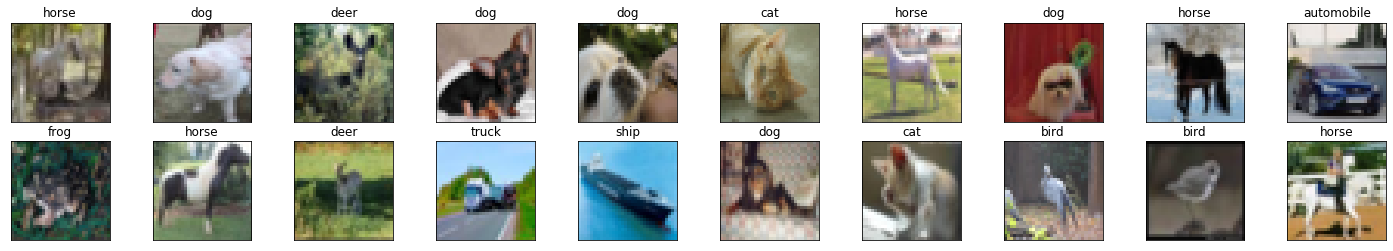

In [22]:
visualize(train_loader)

In [26]:
# Define the CNN architecture

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Conv Layer 1
        self.conv1 = nn.Conv2d(3,16,3,padding=1)
        # Conv Layer 2
        self.conv2 = nn.Conv2d(16,32,3,padding=1)
        # Conv Layer 3
        self.conv3 = nn.Conv2d(32,64,3,padding=1)
        
        # Max Pooling Layer
        self.pool = nn.MaxPool2d(2,2)
        
        # Linear Layers
        self.fc1 = nn.Linear(4*4*64,500)
        self.fc2 = nn.Linear(500,10)
        
        # dropout
        self.dropout = nn.Dropout(0.25)
        
    def forward(self, x):
        # Perform convolutions on input with max pool layer and relu activation
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        # Flatten view of the convolutional layer
        x = x.view(-1,4*4*64)
        
        # Add dropout layer
        x = self.dropout(x)
        
        # Add first linear layer
        x = F.relu(self.fc1(x))
        
        # Add another dropout layer
        x = self.dropout(x)
        
        # Add second linear layer
        x = self.fc2(x)
        
        return x

In [27]:
model = Net()
print(model)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


In [29]:
# Specify loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [31]:
# Train the network

def train(model, train_loader, valid_loader):
    n_epochs = 30
    valid_loss_min = np.Inf
    
    for e in range(1,n_epochs+1):
        
        # Keep track of train and valid loss
        train_loss = 0.0
        valid_loss = 0.0
        
        # Train Model #
        model.train()
        for data, target in train_loader:
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()*data.size(0)
        
        
        # Validate Model #
        model.eval()
        for data, target in valid_loader:
            output = model(data)
            loss = criterion(output, target)
            valid_loss += loss.item()*data.size(0)
        
        
        # Calculate average loss
        train_loss = train_loss/len(train_loader.sampler)
        valid_loss = valid_loss/len(valid_loader.sampler)
        
        # Print the values
        print('Epich: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
             e, train_loss, valid_loss))
        
        # Save model if loss has decreased
        
        if valid_loss <= valid_loss_min:
            print('Validation loss has reduced from {:.6f} to {:.6f}. Saving model ...'.format(
            train_loss, valid_loss))
            torch.save(model.state_dict(), 'model_cifar.pt')
            valid_loss_min = valid_loss

In [37]:
def test(model, test_loader):
    test_loss = 0.0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))

    model.eval()
    for data, target in test_loader:
        output = model(data)
        loss = criterion(output, target)
        test_loss += loss.item()*data.size(0)
        _, pred = torch.max(output, 1)
        correct_tensor = pred.eq(target.data.view_as(pred))
        correct = np.squeeze(correct_tensor.numpy())
        for i in range(20): # over batch_size
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1
    
    # average test loss
    test_loss = test_loss/len(test_loader.dataset)
    print('Test Loss: {:.6f}\n'.format(test_loss))
    for i in range(10):
        if class_total[i] > 0:
            print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
                classes[i], 100 * class_correct[i] / class_total[i],
                np.sum(class_correct[i]), np.sum(class_total[i])))
        else:
            print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

    print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
        100. * np.sum(class_correct) / np.sum(class_total),
        np.sum(class_correct), np.sum(class_total)))

In [32]:
train(model, train_loader, valid_loader)

Epich: 1 	Training Loss: 2.128617 	Validation Loss: 1.832023
Validation loss has reduced from 2.128617 to 1.832023. Saving model ...
Epich: 2 	Training Loss: 1.686416 	Validation Loss: 1.531240
Validation loss has reduced from 1.686416 to 1.531240. Saving model ...
Epich: 3 	Training Loss: 1.476732 	Validation Loss: 1.366157
Validation loss has reduced from 1.476732 to 1.366157. Saving model ...
Epich: 4 	Training Loss: 1.359967 	Validation Loss: 1.245247
Validation loss has reduced from 1.359967 to 1.245247. Saving model ...
Epich: 5 	Training Loss: 1.268377 	Validation Loss: 1.172070
Validation loss has reduced from 1.268377 to 1.172070. Saving model ...
Epich: 6 	Training Loss: 1.184520 	Validation Loss: 1.103517
Validation loss has reduced from 1.184520 to 1.103517. Saving model ...
Epich: 7 	Training Loss: 1.114428 	Validation Loss: 1.031658
Validation loss has reduced from 1.114428 to 1.031658. Saving model ...
Epich: 8 	Training Loss: 1.046879 	Validation Loss: 1.005538
Validati

In [36]:
model.load_state_dict(torch.load('model_cifar.pt'))
test(model, test_loader)

Test Loss: 0.744106

Test Accuracy of airplane: 82% (829/1000)
Test Accuracy of automobile: 83% (834/1000)
Test Accuracy of  bird: 63% (631/1000)
Test Accuracy of   cat: 47% (474/1000)
Test Accuracy of  deer: 68% (689/1000)
Test Accuracy of   dog: 70% (709/1000)
Test Accuracy of  frog: 86% (864/1000)
Test Accuracy of horse: 78% (786/1000)
Test Accuracy of  ship: 82% (827/1000)
Test Accuracy of truck: 84% (842/1000)

Test Accuracy (Overall): 74% (7485/10000)
